In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
data_file = r'C:\Users\Barbara\Documents\Radboud uni\Internship\2p_data\Ribolla\20230315\neural_data.pickle'
filehandler = open(data_file, 'rb')
neural_data = pickle.load(filehandler)
filehandler.close()

In [3]:
neural_data.keys()

dict_keys(['traces', 'footprints', 'df_f', 'deconvolved', 'positions', 'contour'])

In [4]:
tr = neural_data['traces']
spikes = neural_data['deconvolved']
positions = neural_data['positions']

In [5]:
#dimension consists of 288 rows [0] and 96733 columns [1]
tr.shape

(191, 63904)

### Firing rate

In [6]:
print (len(spikes), 'neurons')

191 neurons


C:\Users\Barbara\AppData\Local\Temp\ipykernel_20920\3824001214.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.eventplot(np.array(spikes)[ids], linelengths=lineSize, color = colorcode)


Text(0, 0.5, 'Index of a neuron')

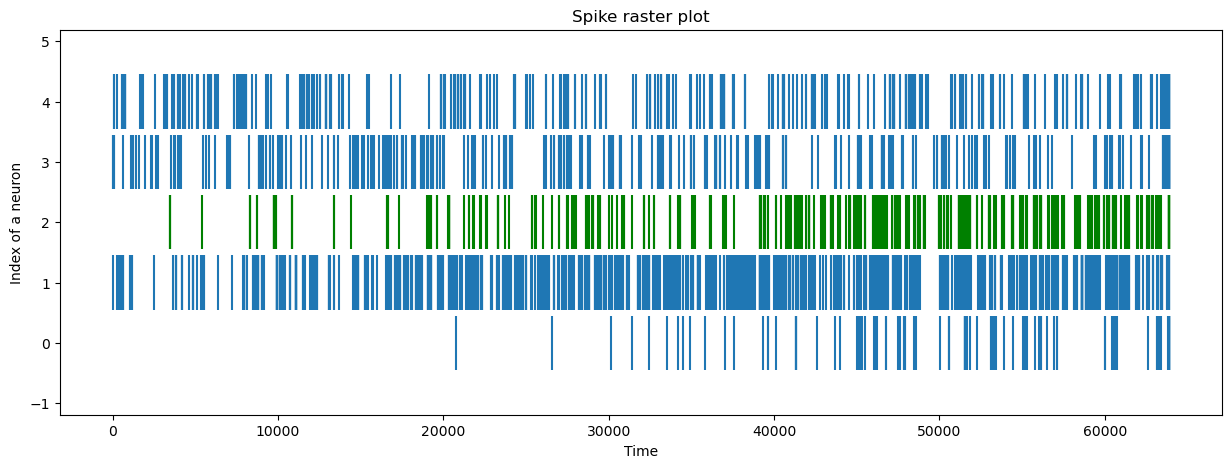

In [7]:
plt.figure(figsize=(15,5))
ids = [0,2,10,70,100]
colorcode = ['C0','C0','green','C0','C0']
lineSize = [0.9, 0.9, 0.9, 0.9, 0.9]
plt.eventplot(np.array(spikes)[ids], linelengths=lineSize, color = colorcode)

plt.title('Spike raster plot')
plt.xlabel('Time')
plt.ylabel('Index of a neuron')

Text(0, 0.5, 'Amplitude of the spike')

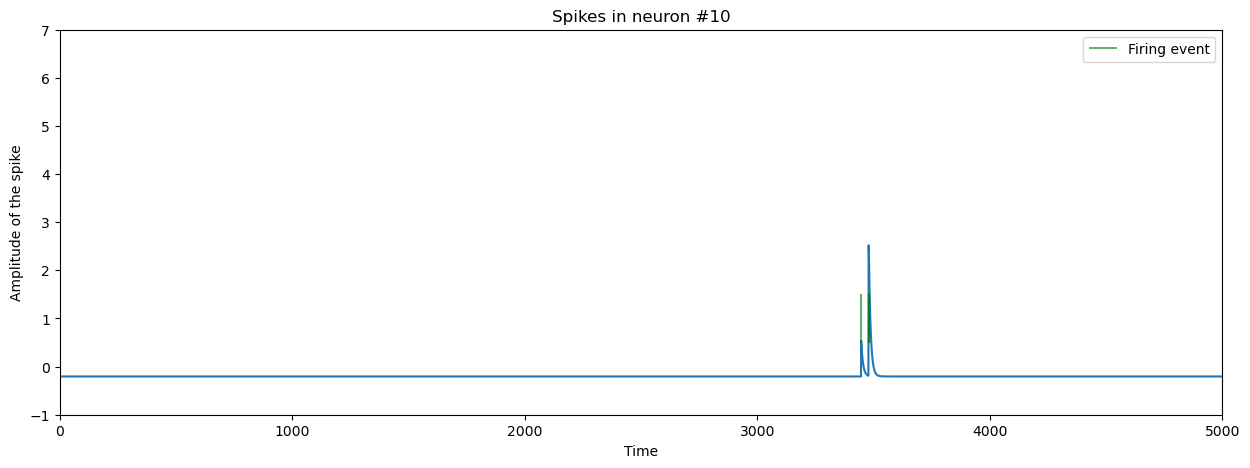

In [8]:
from scipy.stats import zscore

plt.figure(figsize=(15,5))
neuron = 10
plt.plot(zscore(tr[neuron]))
plt.eventplot(spikes[neuron], color = 'green', alpha = 0.6, label = 'Firing event')
plt.legend(loc = 'upper right')
plt.xlim([0,5000])
plt.ylim([-1,7])
plt.title('Spikes in neuron #10')
plt.xlabel('Time')
plt.ylabel('Amplitude of the spike')

In [9]:
#number of samples per second is 30 Hz
sampling_rate = 30
#calculate the period T (s) by dividing the Y value of a trace (px) by the frequency (px/s)
T = tr.shape[1]/sampling_rate
print (T, 's')

2130.133333333333 s


Text(0.5, 1.0, '2023-03-15')

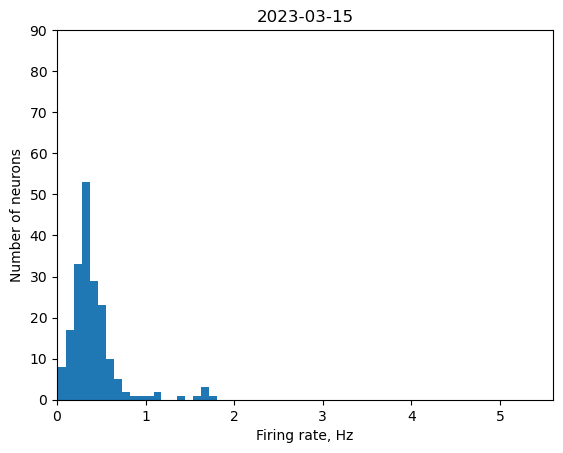

In [18]:
# list comprehension
spike_counts = [len(s) for s in spikes]
#Creating the firing rates by dividing the generated by 'asarray' array of spike counts by period T
firing_rates = np.asarray(spike_counts)/T

#Plot the firing rates distribution: how many neurons (Y) fire with a specific firing rate (X,bin)
plt.hist(firing_rates,bins = 20)

plt.xlim([0,5.6])
plt.ylim([0,90])
plt.xlabel('Firing rate, Hz')
plt.ylabel('Number of neurons')
plt.title('2023-03-15')

### Correlation

size of correlation matrix is  (191, 191)


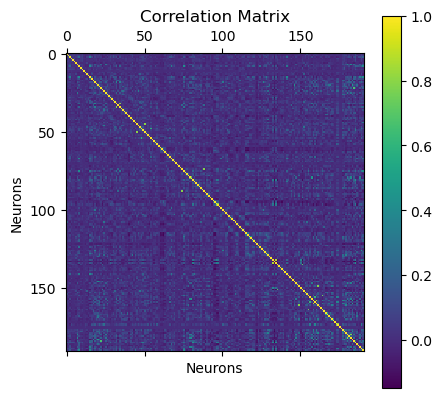

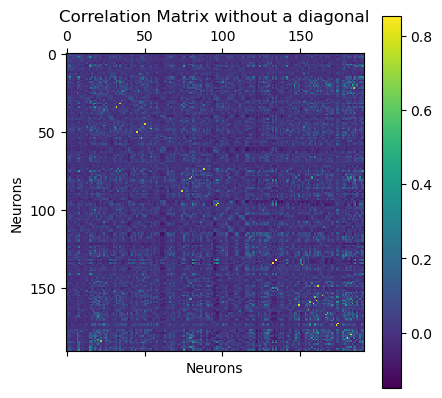

In [11]:
'''Correlation matrix with a diagonal'''
# compute correlation matrix
cormat = np.corrcoef(tr)

#check size of correlation matrix, it should be neurons x neurons
print('size of correlation matrix is ', cormat.shape)

plt.matshow(cormat)
plt.colorbar()
plt.xlabel('Neurons')
plt.ylabel('Neurons')
plt.title('Correlation Matrix')
plt.show()


'''Correlation matrix without a diagonal'''
# compute correlation matrix
cormat = np.corrcoef(tr)
np.fill_diagonal(cormat,0)

plt.matshow(cormat)
plt.colorbar()
plt.xlabel('Neurons')
plt.ylabel('Neurons')
plt.title('Correlation Matrix without a diagonal')
plt.show()

Text(0, 0.5, 'Number of neurons')

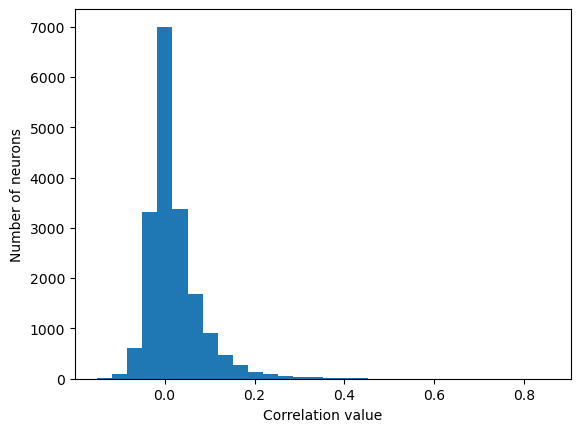

In [12]:
#Plot the distribution of correlations of a flattened (?) matrix
plt.hist(cormat[np.triu_indices_from(cormat,k=1)],bins=30)
plt.xlabel('Correlation value')
plt.ylabel('Number of neurons')

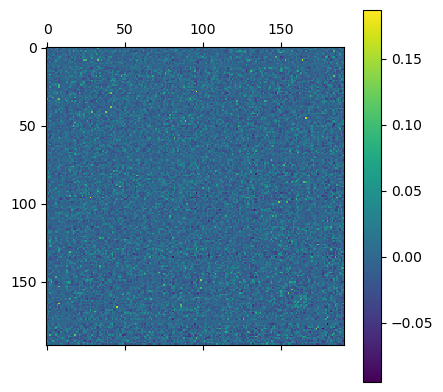

In [13]:
def randomize_traces(tr):
    '''
    Takes trace matrix, returns matrix of traces each shifted by a random amount.
    PARAMETERS:
    tr (n_neurons x n_timepoints): 2d array of traces
    
    RETURNS:
    randomized_traces (n_neurons x n_timepoints): the randomized traces
    '''

    randomized_tr = np.zeros_like(tr)
    #zeros_like() function in Python is used to return an array of zeros ( 0 ) 
    #with the same shape and data type as the array passed to it
    for i,vec in enumerate(tr):
        rand_shift = np.random.choice(np.arange(len(vec))) #Generates a random sample from a given 1-D array
        randomized_tr[i,:] = np.roll(vec,rand_shift)     #Roll array elements along a given axis
        
    return randomized_tr

# New name for the function
r_tr = randomize_traces(tr)

# The correlation matrix of randomized traces
rcormat = np.corrcoef(r_tr)
np.fill_diagonal(rcormat,0)

plt.matshow(rcormat)
plt.colorbar()

Text(0.5, 1.0, '2023-03-15')

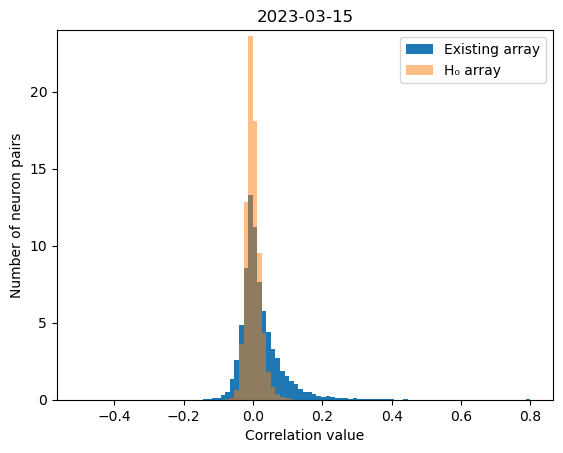

In [25]:
# Return the indices for the upper-triangle of arr., k=1 is a filled diagonal

plt.hist(cormat[np.triu_indices_from(cormat,k=1)],bins=np.linspace(-0.5,0.8,100), density=True,
         label='Existing array');
plt.hist(rcormat[np.triu_indices_from(rcormat,k=1)],bins=np.linspace(-0.5,0.8,100),density=True, alpha=0.5,
         label='H\u2080 array');
plt.legend(loc="upper right")

plt.ylim([0,24])
plt.xlabel('Correlation value')
plt.ylabel('Number of neuron pairs')
plt.title('2023-03-15')

In [15]:
# To create the list of shuffled null hypothesis correlations
def compute_null_corr_distr(tr,n_shuff=10):
    '''
    Takes the array of the neural traces (n_neurons x n_timepoints) and (optionally) the number of shuffles.
    Returns an array with the distirbution of correlations on the shuffled data.
    '''
    shuff_corr = []
    for _ in range(n_shuff):
        r_tr = randomize_traces(tr)
        rcormat = np.corrcoef(r_tr)
        np.fill_diagonal(cormat,0)
        flat_rcormat = list(rcormat[np.triu_indices_from(rcormat,k=1)])
        shuff_corr = shuff_corr + flat_rcormat #joins the lists, not sums them up

    shuff_corr = np.asarray(shuff_corr)
    
    return shuff_corr

null_corrs = compute_null_corr_distr(tr,n_shuff=20)
print(len(null_corrs))

362900


### Percentiles

In [16]:
th5 = np.percentile(null_corrs,5)
th95 = np.percentile(null_corrs,95)

mat_indices = np.triu_indices_from(cormat,k=1) #Indices of existing correlations array
flat_corr = cormat[mat_indices]

pos_corr = []
neg_corr = []
for i,c in enumerate(flat_corr):
    if c> th95:
        pos_corr.append((mat_indices[0][i],mat_indices[1][i]))
    elif c < th5:
        neg_corr.append((mat_indices[0][i],mat_indices[1][i]))

print(f'fraction of positive correlated pairs: {len(pos_corr)/len(mat_indices[0])}')
print(f'fraction of negative correlated pairs: {len(neg_corr)/len(mat_indices[0])}')

fraction of positive correlated pairs: 0.2720308624965555
fraction of negative correlated pairs: 0.11931661614769909
